Calculating Bollinger Bands (Window: 96, Continuous)...
Data Ready: 75914 rows (Dropped 46716 initial NaN rows)
Simulating BB Mean Reversion...
Total Trades Executed: 1952.0

 PERFORMANCE REPORT: Bollinger Band Mean Reversion (AUD)

[Text Output]
   Quarter  Gross SR    Net SR  Ann. Vol ($)   Gross CR    Net CR  Gross CumP&L  Net CumP&L  Trades (AUD)  Av. Trades      Stat
0  2023_Q1  3.038549  2.122516   5930.954887  10.139985  6.731842        4767.0      3297.0         294.0    4.454545  1.935682
1  2023_Q3  0.625984 -0.520443   4646.899426   0.783292 -0.567178         787.0      -643.0         286.0    4.268657 -0.000000
2  2023_Q4  1.641140  0.352635   4406.828823   6.680956  1.137628        1937.0       407.0         306.0    4.636364 -0.000000
3  2024_Q2 -2.891807 -4.192403   4060.575528  -3.138413 -3.594504       -3081.0     -4391.0         262.0    4.030769 -6.942678
4  2024_Q4  3.201193  1.865717   3786.080494  10.028475  5.122374        3192.0      1822.0         274.0    4.21

,Quarter,Gross SR,Net SR,Ann. Vol ($),Gross CR,Net CR,Gross CumP&L,Net CumP&L,Trades (AUD),Av. Trades,Stat
0,2023_Q1,3.04,2.12,"$5,931",10.14,6.73,"$4,767","$3,297",294,4.5,1.9357
1,2023_Q3,0.63,-0.52,"$4,647",0.78,-0.57,$787,$-643,286,4.3,-0.0000
2,2023_Q4,1.64,0.35,"$4,407",6.68,1.14,"$1,937",$407,306,4.6,-0.0000
3,2024_Q2,-2.89,-4.19,"$4,061",-3.14,-3.59,"$-3,081","$-4,391",262,4.0,-6.9427
4,2024_Q4,3.20,1.87,"$3,786",10.03,5.12,"$3,192","$1,822",274,4.2,0.8193
5,2025_Q1,0.55,-0.88,"$3,452",1.00,-1.17,$483,$-757,248,3.9,-0.0000
6,2025_Q2,-0.45,-1.22,"$7,210",-0.91,-2.13,$-852,"$-2,262",282,4.3,-1.4009
7,TOTAL,-,-,"$4,948",-,-,"$7,233","$-2,527","1,952",4.3,-5.5885



 TOTAL RANKING SCORE: -5.5885


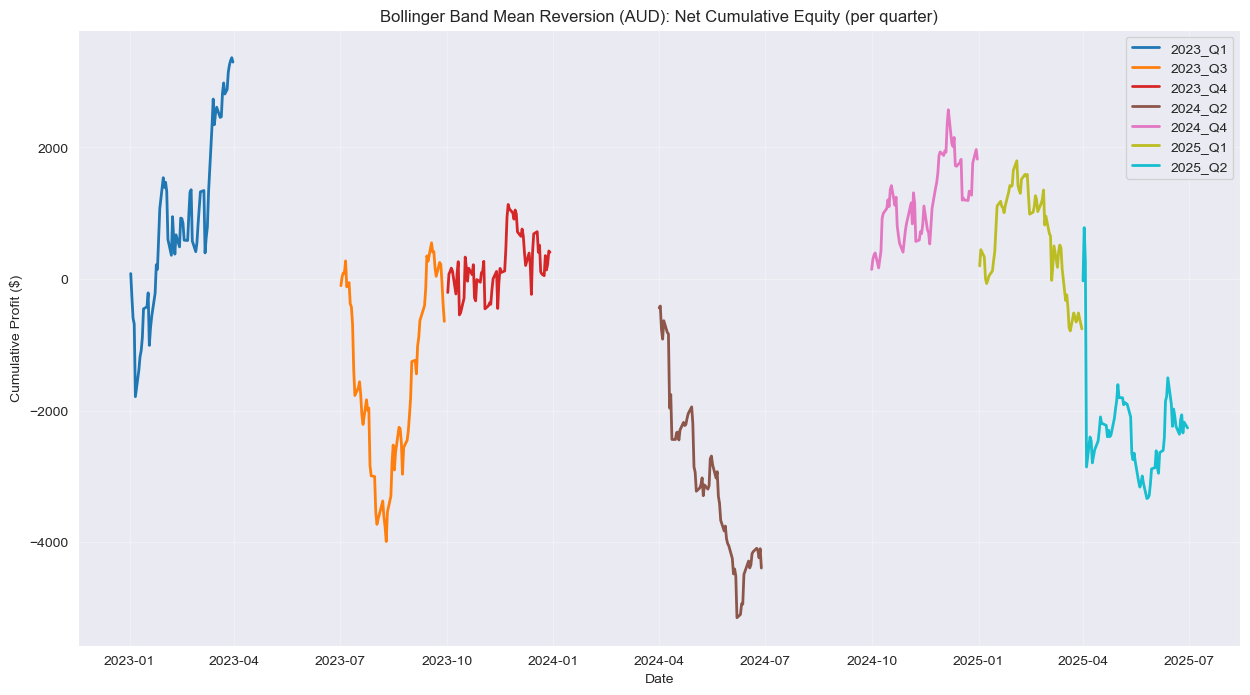

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

# Filter warnings for cleaner output
warnings.filterwarnings('ignore')


# ==========================================
# 1. Configuration
# ==========================================
class Config:
    # File Path (Group 2 Processed Data)
    FILE_PATH = '../../preprocess/df_g2_processed.pkl'

    # Asset
    ASSETS = ['AUD']

    # Contract Specifications
    # 1 pip (0.0001) move = $10 (Standard Lot). Cost set conservatively at $5 per trade.
    SPECS = {
        'AUD': {'point_val': 100000.0, 'cost': 5.0}
    }

    # --- Strategy Parameters (Bollinger Bands Mean Reversion) ---

    # [Adjustment] Window Size
    # Adjusted to 288 (approx 24 hours / 1 day) to ensure signal generation.
    BB_WINDOW = 96

    # Sigma
    BB_SIGMA = 2.0

    ANNUALIZATION = 252


# ==========================================
# 2. Data Preparation (Continuous Calculation)
# ==========================================
def prepare_bb_data(file_path, cfg):
    """
    Loads data and calculates Bollinger Bands for AUD.
    Calculates continuously across quarters to avoid data loss.
    """
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

    # Ensure required columns exist
    req_cols = cfg.ASSETS + ['Quarter_ID', 'can_trade', 'force_exit']
    if 'Is_In_Sample' in df.columns:
        req_cols.append('Is_In_Sample')

    if 'AUD' not in df.columns:
        print("Error: 'AUD' column not found in the dataframe.")
        return None

    data = df.copy()  # Use all columns including index

    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    print(f"Calculating Bollinger Bands (Window: {cfg.BB_WINDOW}, Continuous)...")

    # =========================================================
    # Do NOT groupby Quarter_ID for rolling metrics.
    # Calculate on the entire dataset to preserve history.
    # =========================================================
    price = data['AUD']

    # 1. Calculate Moving Average (Center Line)
    ma = price.rolling(window=cfg.BB_WINDOW).mean()

    # 2. Calculate Standard Deviation
    std = price.rolling(window=cfg.BB_WINDOW).std()

    # 3. Calculate Bands
    upper = ma + (cfg.BB_SIGMA * std)
    lower = ma - (cfg.BB_SIGMA * std)

    data['MA'] = ma
    data['Upper'] = upper
    data['Lower'] = lower

    # Drop initial NaNs from rolling window (only at the very beginning of the dataset)
    before_len = len(data)
    data.dropna(subset=['MA', 'Upper', 'Lower'], inplace=True)
    print(f"Data Ready: {len(data)} rows (Dropped {before_len - len(data)} initial NaN rows)")

    return data


# ==========================================
# 3. Strategy Logic (Signal Execution)
# ==========================================
def run_bb_strategy(df, cfg):
    """
    Executes trades based on Bollinger Band Mean Reversion.
    Strictly follows 'force_exit' and 'can_trade' flags.
    """
    data = df.copy()

    price = data['AUD'].values
    upper = data['Upper'].values
    lower = data['Lower'].values
    ma = data['MA'].values

    # Flags from Preprocessing
    can_trade = data['can_trade'].values
    force_exit = data['force_exit'].values
    in_sample = data['Is_In_Sample'].values

    pos_aud = np.zeros(len(data), dtype=int)
    curr_pos = 0

    print(f"Simulating BB Mean Reversion...")

    for i in range(len(data)):
        # Priority 1: Force Exit (e.g., 16:45 for Group 2)
        if force_exit[i]:
            curr_pos = 0
            pos_aud[i] = 0
            continue

        # Priority 2: Check Trading Hours / Gaps
        if not can_trade[i]:
            curr_pos = 0
            pos_aud[i] = 0
            continue

        p = price[i]
        u = upper[i]
        l = lower[i]
        m = ma[i]

        # --- Trading Logic ---

        # 1. Check Entry
        if curr_pos == 0:
            if p > u:
                # Price touched Upper Band -> Short
                curr_pos = -1
            elif p < l:
                # Price touched Lower Band -> Long
                curr_pos = 1

        # 2. Check Exit (Mean Reversion to MA)
        elif curr_pos == 1:  # Currently Long
            # Exit if price recovers to MA (or goes higher)
            if p >= m:
                curr_pos = 0

        elif curr_pos == -1:  # Currently Short
            # Exit if price drops to MA (or goes lower)
            if p <= m:
                curr_pos = 0

        pos_aud[i] = curr_pos

    # Shift positions to align with next bar's return (Strategy execution delay)
    data['Pos_AUD'] = pd.Series(pos_aud, index=data.index).shift(1).fillna(0)

    # Calculate Number of Trades for verification
    n_trades = data['Pos_AUD'].diff().abs().sum()
    print(f"Total Trades Executed: {n_trades}")

    return data


# ==========================================
# 4. P&L Calculation & Aggregation
# ==========================================
def calculate_metrics(data, cfg):
    """
    Calculates P&L and aggregates to Daily.
    """
    df = data.copy()

    df['dPrice_AUD'] = df['AUD'].diff()

    # Gross PnL
    df['Gross_PnL_Total'] = df['Pos_AUD'] * df['dPrice_AUD'] * cfg.SPECS['AUD']['point_val']

    # Transaction Costs
    df['Trades_AUD'] = df['Pos_AUD'].diff().abs().fillna(0)
    df['Cost_Total'] = df['Trades_AUD'] * cfg.SPECS['AUD']['cost']

    # Net PnL
    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_AUD']

    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Trades_AUD': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    # Filter for valid quarters and In-Sample only
    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats


# ==========================================
# 5. Performance Stats & Reporting
# ==========================================
def generate_quarterly_stats(daily_df, cfg):
    """
    Generates summary statistics table.
    """
    if daily_df.empty:
        return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()

        if len(d_q) == 0:
            continue

        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        # Sharpe Ratio
        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if std_g != 0 else 0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if std_n != 0 else 0

        ann_vol_n = std_n * np.sqrt(cfg.ANNUALIZATION)

        # Calmar Ratio
        years = len(d_q) / cfg.ANNUALIZATION

        equity_g = d_q['Gross_PnL_Total'].cumsum()
        max_dd_g = (equity_g.cummax() - equity_g).max()
        gross_cr = (gross_cum_pnl / years / max_dd_g) if (max_dd_g > 0) else 0

        equity_n = d_q['Net_PnL_Total'].cumsum()
        max_dd_n = (equity_n.cummax() - equity_n).max()
        net_cr = (net_cum_pnl / years / max_dd_n) if (max_dd_n > 0) else 0

        trades_aud = d_q['Trades_AUD'].sum()
        av_ntrades = d_q['Total_Trades'].mean()

        # Summary Statistic (Ranking Score)
        abs_pnl_scaled = abs(net_cum_pnl) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        term_2 = max(0, log_term)
        stat = (net_sr - 0.5) * term_2

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': ann_vol_n,
            'Gross CR': gross_cr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Trades (AUD)': trades_aud,
            'Av. Trades': av_ntrades,
            'Stat': stat
        })

    return pd.DataFrame(stats_list)


# ==========================================
# [UPDATE] Plot Function: Reset per Quarter
# ==========================================
def plot_equity_curve(daily_stats):
    if daily_stats is None or daily_stats.empty:
        return

    quarters = sorted(daily_stats['Quarter_ID'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(quarters)))
    plt.figure(figsize=(15, 8))

    for i, q in enumerate(quarters):
        d_q = daily_stats[daily_stats['Quarter_ID'] == q].copy()
        d_q = d_q.sort_index()
        # Reset cumulative per quarter:
        equity = d_q['Net_PnL_Total'].cumsum()
        plt.plot(d_q.index, equity, label=q, color=colors[i], lw=2)

    plt.title('Bollinger Band Mean Reversion (AUD): Net Cumulative Equity (per quarter)')
    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


# ==========================================
# 6. Main Execution
# ==========================================
if __name__ == "__main__":
    cfg = Config()

    # 1. Prepare Data (BB Calculation - Continuous)
    df_prep = prepare_bb_data(cfg.FILE_PATH, cfg)

    if df_prep is not None and not df_prep.empty:
        # 2. Run Strategy (With Force Exit Logic)
        df_res = run_bb_strategy(df_prep, cfg)

        # 3. Calculate Metrics
        daily_data = calculate_metrics(df_res, cfg)

        # 4. Generate Report
        stats_table = generate_quarterly_stats(daily_data, cfg)

        # --- Display Table ---
        print("\n" + "=" * 80)
        print(" PERFORMANCE REPORT: Bollinger Band Mean Reversion (AUD)")
        print("=" * 80)

        if not stats_table.empty:
            total_score = stats_table['Stat'].sum()
            total_gross_pnl = stats_table['Gross CumP&L'].sum()
            total_net_pnl = stats_table['Net CumP&L'].sum()
            total_trades_aud = stats_table['Trades (AUD)'].sum()

            std_global = daily_data['Net_PnL_Total'].std()
            vol_global = std_global * np.sqrt(cfg.ANNUALIZATION)

            display_df = stats_table.copy()
            sum_row = pd.DataFrame([{
                'Quarter': 'TOTAL',
                'Gross SR': np.nan,
                'Net SR': np.nan,
                'Ann. Vol ($)': vol_global,
                'Gross CR': np.nan,
                'Net CR': np.nan,
                'Gross CumP&L': total_gross_pnl,
                'Net CumP&L': total_net_pnl,
                'Trades (AUD)': total_trades_aud,
                'Av. Trades': stats_table['Av. Trades'].mean(),
                'Stat': total_score
            }])

            display_df = pd.concat([display_df, sum_row], ignore_index=True)

            format_dict = {
                'Gross SR': '{:.2f}', 'Net SR': '{:.2f}',
                'Ann. Vol ($)': '${:,.0f}',
                'Gross CR': '{:.2f}', 'Net CR': '{:.2f}',
                'Gross CumP&L': '${:,.0f}', 'Net CumP&L': '${:,.0f}',
                'Trades (AUD)': '{:,.0f}',
                'Av. Trades': '{:.1f}',
                'Stat': '{:.4f}'
            }

            print("\n[Text Output]")
            print(display_df.to_string(
                formatters={k: v.format for k, v in format_dict.items() if isinstance(v, str) == False}, na_rep="-"))

            print("\n[Table Output]")
            try:
                subset_stat = pd.IndexSlice[0:len(display_df) - 2, ['Stat']]
                styled_df = display_df.style.format(format_dict, na_rep="-") \
                    .background_gradient(subset=subset_stat, cmap='RdYlGn') \
                    .apply(lambda x: ['font-weight: bold' if x.name == len(display_df) - 1 else '' for i in x], axis=1)
                display(styled_df)
            except:
                pass

            print(f"\n{'=' * 40}")
            print(f" TOTAL RANKING SCORE: {total_score:.4f}")
            print(f"{'=' * 40}")

            # 5. Plot
            plot_equity_curve(daily_data)
        else:
            print("⚠️ No trades generated. Check logic or data availability.")
    else:
        print("Data preparation failed.")